# Problem Definition - Auto ticket classification

### In this case study, you will be working as an NLP engineer for a financial company that wants to automate its customer support tickets system. 
### As a financial company, the firm has many products and services such as credit cards, banking and mortgages/loans.

### We will be following these eight major steps to come up with a ticket classification problem
1. Data loading
2. Text preprocessing
3. Exploratory data analysis (EDA)
4. Feature extraction
5. Topic modelling 
6. Model building using supervised learning
7. Model training and evaluation
8. Model inference

# Data loading

In [ ]:
# we will load the data from google drive
# attaching google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load all libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

In [ ]:
# load nlp libs
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
# read data from file
f = open('/content/drive/MyDrive/data/complaints-2021-05-14_08_16.json', 'r')
data = json.load(f)
df = pd.json_normalize(data)

KeyboardInterrupt: ignored

In [ ]:
df.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [ ]:
df.shape

(78313, 22)

In [ ]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [ ]:
#Assign new column names
df.rename(columns ={'_index': 'index', '_type': 'type', '_id': 'id', '_score': 'score', '_source.tags': 'tags', 
                    '_source.zip_code': 'zip_code', '_source.complaint_id': 'complaint_id',
                    '_source.complaint_id': 'complaint_id', '_source.issue': 'issue',
                    '_source.date_received': 'date_received', '_source.state': 'state',
                    '_source.consumer_disputed': 'consumer_disputed', '_source.product': 'product',
                    '_source.company_response': 'company_response', '_source.company': 'company',
                    '_source.submitted_via': 'submitted_via', '_source.date_sent_to_company': 'date_sent_to_company',
                    '_source.company_public_response': 'company_public_response', '_source.sub_product': 'sub_product',
                    '_source.timely': 'timely', '_source.complaint_what_happened': 'complaint_what_happened',
                    '_source.sub_issue': 'sub_issue', '_source.consumer_consent_provided': 'consumer_consent_provided'}, inplace = True)

### Lets understand each fileds

# since we are classifying the tickets based complaint description
fields of out interest is 
1. issue
2. state
3. response
4. product
4. complaint what happened 
5. sub_issue

In [ ]:
## All row has same value, can drop this column
df[['issue', 'sub_issue', 'company_response', 'product','sub_product', 'complaint_what_happened']].head(10)

,issue,sub_issue,company_response,product,sub_product,complaint_what_happened
0,Attempts to collect debt not owed,Debt is not yours,Closed with explanation,Debt collection,Credit card debt,
1,Written notification about debt,Didn't receive enough information to verify debt,Closed with explanation,Debt collection,Credit card debt,Good morning my name is XXXX XXXX and I apprec...
2,"Other features, terms, or problems",Problem with rewards from credit card,Closed with explanation,Credit card or prepaid card,General-purpose credit card or charge card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Trouble during payment process,None,Closed with explanation,Mortgage,Conventional home mortgage,
4,Fees or interest,Charged too much interest,Closed with explanation,Credit card or prepaid card,General-purpose credit card or charge card,
5,Managing an account,Problem using a debit or ATM card,Closed with monetary relief,Checking or savings account,Checking account,
6,Managing an account,Problem using a debit or ATM card,Closed with monetary relief,Checking or savings account,Checking account,
7,Trouble during payment process,None,Closed with explanation,Mortgage,Conventional home mortgage,
8,Closing an account,Company closed your account,Closed with explanation,Checking or savings account,Checking account,
9,Managing an account,Cashing a check,Closed with monetary relief,Checking or savings account,Checking account,


In [ ]:
df['issue'].value_counts()[df['issue'].value_counts() > 500]

Loan modification,collection,foreclosure                                            9743
Managing an account                                                                 7410
Loan servicing, payments, escrow account                                            5360
Problem with a purchase shown on your statement                                     4055
Account opening, closing, or management                                             3879
Deposits and withdrawals                                                            3111
Incorrect information on your report                                                2714
Closing an account                                                                  1830
Billing disputes                                                                    1744
Trouble during payment process                                                      1673
Struggling to pay mortgage                                                          1552
Other                

In [ ]:
len(df['sub_issue'].value_counts())

205

In [ ]:
df['company_response'].value_counts()

Closed with explanation            60230
Closed with monetary relief        10129
Closed with non-monetary relief     4383
Closed without relief               2009
Closed with relief                   813
Closed                               628
In progress                          119
Untimely response                      2
Name: company_response, dtype: int64

In [ ]:
df['product'].value_counts()

Mortgage                                                                        22725
Checking or savings account                                                     12147
Credit card or prepaid card                                                     10797
Credit card                                                                     10373
Bank account or service                                                          9816
Credit reporting, credit repair services, or other personal consumer reports     4310
Debt collection                                                                  3201
Money transfer, virtual currency, or money service                               1500
Consumer Loan                                                                    1029
Vehicle loan or lease                                                             892
Student loan                                                                      866
Money transfers                                       

In [ ]:
df['sub_product'].value_counts()

Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
                                              ...  
Gift or merchant card                             4
Government benefit payment card                   4
ID prepaid card                                   2
Medical debt                                      2
Electronic Benefit Transfer / EBT card            1
Name: sub_product, Length: 72, dtype: int64

In [ ]:
df['complaint_what_happened'].value_counts()

We see lot of blank complaint description (complaint_what_happened)

In [ ]:
df[df['complaint_what_happened'] == ''][['issue', 'sub_issue', 'company_response', 'product','sub_product', 'complaint_what_happened']]

,issue,sub_issue,company_response,product,sub_product,complaint_what_happened
0,Attempts to collect debt not owed,Debt is not yours,Closed with explanation,Debt collection,Credit card debt,
3,Trouble during payment process,None,Closed with explanation,Mortgage,Conventional home mortgage,
4,Fees or interest,Charged too much interest,Closed with explanation,Credit card or prepaid card,General-purpose credit card or charge card,
5,Managing an account,Problem using a debit or ATM card,Closed with monetary relief,Checking or savings account,Checking account,
6,Managing an account,Problem using a debit or ATM card,Closed with monetary relief,Checking or savings account,Checking account,
...,...,...,...,...,...,...
78304,Applying for a mortgage or refinancing an exis...,None,Closed with monetary relief,Mortgage,Conventional home mortgage,
78305,Closing an account,Funds not received from closed account,Closed with explanation,Checking or savings account,Other banking product or service,
78306,Managing an account,Deposits and withdrawals,Closed with explanation,Checking or savings account,Checking account,
78307,Applying for a mortgage or refinancing an exis...,None,Closed with explanation,Mortgage,Conventional home mortgage,


Since assignment is based on NPM based ticket classification, complaint_what_happened is right filed for further analysis.
We have lot of rows with blank complaint_what_happened. Lets get rid of these rows as this will lot help us for NLP analysis

In [ ]:
df = df[~(df['complaint_what_happened'] == '')]
df.shape

(21072, 22)

## 2. Text preprocessing

In [ ]:
df['complaint_what_happened'].head(10)

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
15                        Can you please remove inquiry
17    With out notice J.P. Morgan Chase restricted m...
20    During the summer months, I experience a decli...
21    On XXXX XX/XX/2019, I made a {$300.00} payment...
23    I have a Chase credit card which is incorrectl...
Name: complaint_what_happened, dtype: object

We see text has lot of noice 
1. XXXX string
2. Numbers
3. special char's $, {, [ etc.

In [ ]:
import re

def clean_text(text):
  text = text.lower()
  pattern = re.compile('[\(\[].*?[\)\]]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[^\w\s]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[0-9]')
  text = re.sub(pattern, '', text)
  return text


In [ ]:
df_comp = pd.DataFrame()
df_comp['complaints'] = df['complaint_what_happened'].apply(lambda text: clean_text(text))
df_comp.head(10)

,complaints
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in xxxx and was t...
10,chase card was reported on xxxx however fraudu...
11,on xxxx while trying to book a xxxx xxxx tic...
14,my grand son give me check for i deposit it i...
15,can you please remove inquiry
17,with out notice jp morgan chase restricted my ...
20,during the summer months i experience a declin...
21,on xxxx xxxx i made a payment to an online re...
23,i have a chase credit card which is incorrectl...


In [ ]:
# lets get lammatized string for complaints
# lets use Spacy for this
# install Spacy

!pip install spacy

In [ ]:
import spacy
from nltk.corpus import stopwords
nltk.download('stopwords')

load_model = spacy.load('en', disable = ['parser', 'ner'])

def lammatize_text(text):
  text = load_model(text)
  return ' '.join(token.lemma_ for token in text if not token.text in set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from tqdm import tqdm

lamm_comp = []
for text in tqdm(df_comp['complaints']):
  text_lamm = lammatize_text(text)
  lamm_comp.append(text_lamm)

df_comp['lammatized_comp'] = lamm_comp
df_comp.to_csv('df_comp.csv', index=False)

100%|██████████| 21072/21072 [16:08<00:00, 21.75it/s]


In [ ]:
print(df_comp['complaints'].head(1))
print(df_comp['lammatized_comp'].head(1))

1    good morning my name is xxxx xxxx and i apprec...
Name: complaints, dtype: object
1    good morning name xxxx xxxx appreciate could h...
Name: lammatized_comp, dtype: object


In [ ]:
# extract POS tag and remove all non NOUN POS tag words

def pos_tag(text):
  doc = nlp(text)
  result = []
  for token in doc:
    if token.pos_ == 'NOUN':
      output = result.append(token.text)
    
  return result

In [ ]:
df_comp['comp_POS_removed'] = df_comp['complaints'].apply(lambda x: pos_tag(x))
df_comp.head(10)

,complaints,lammatized_comp,comp_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,"[morning, name, stop, bank, cardmember, servic..."
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgrade xxxx xxxx card xxxx tell agent upgrade...,"[card, agent, anniversary, date, agent, inform..."
10,chase card was reported on xxxx however fraudu...,chase card report xxxx however fraudulent appl...,"[card, application, identity, consent, service..."
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx try book xxxx xxxx ticket come across...,"[xxxx, ticket, offer, ticket, rewards, card, i..."
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...,"[son, chase, account, fund, bank, account, mon..."
15,can you please remove inquiry,please remove inquiry,[inquiry]
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,"[notice, account, debit, card, branch, custome..."
20,during the summer months i experience a declin...,summer month experience decline income due emp...,"[summer, months, decline, income, employment, ..."
21,on xxxx xxxx i made a payment to an online re...,xxxx xxxx make payment online retailer use c...,"[payment, retailer, chase, pay, chase, website..."
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly report datum cre...,"[chase, credit, card, data, credit, report, co..."


In [ ]:
df_comp.to_csv('df_compv1.csv', index=False)

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:

df_comp = pd.read_csv('/content/drive/MyDrive/data/df_compv1.csv')
df_comp.head(10)

,complaints,lammatized_comp,comp_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,"['morning', 'name', 'stop', 'bank', 'cardmembe..."
1,i upgraded my xxxx xxxx card in xxxx and was t...,upgrade xxxx xxxx card xxxx tell agent upgrade...,"['card', 'agent', 'anniversary', 'date', 'agen..."
2,chase card was reported on xxxx however fraudu...,chase card report xxxx however fraudulent appl...,"['card', 'application', 'identity', 'consent',..."
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx try book xxxx xxxx ticket come across...,"['xxxx', 'ticket', 'offer', 'ticket', 'rewards..."
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...,"['son', 'chase', 'account', 'fund', 'bank', 'a..."
5,can you please remove inquiry,please remove inquiry,['inquiry']
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,"['notice', 'account', 'debit', 'card', 'branch..."
7,during the summer months i experience a declin...,summer month experience decline income due emp...,"['summer', 'months', 'decline', 'income', 'emp..."
8,on xxxx xxxx i made a payment to an online re...,xxxx xxxx make payment online retailer use c...,"['payment', 'retailer', 'chase', 'pay', 'chase..."
9,i have a chase credit card which is incorrectl...,chase credit card incorrectly report datum cre...,"['chase', 'credit', 'card', 'data', 'credit', ..."


In [ ]:
# test = " ".join(str(item) for item in df_comp['comp_POS_removed'][:1])
# test
import ast 
# test = df_comp['comp_POS_removed'][:1][0]
# print(test)
# print(type(test))
# res = ast.literal_eval(test)
# # res = json.loads(test)
# print(res)
# print(type(res))

# # for item in list(df_comp['comp_POS_removed'][:1][0]):
# #   print(item)
# test = " ".join(res)
# print(test)
df_comp['comp_POS_removed'] = df_comp['comp_POS_removed'].apply(lambda x: ' '.join(ast.literal_eval(x)))

SyntaxError: ignored

In [ ]:
df_comp.head(10)

,complaints,lammatized_comp,comp_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...
1,i upgraded my xxxx xxxx card in xxxx and was t...,upgrade xxxx xxxx card xxxx tell agent upgrade...,card agent anniversary date agent information ...
2,chase card was reported on xxxx however fraudu...,chase card report xxxx however fraudulent appl...,card application identity consent services cre...
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx try book xxxx xxxx ticket come across...,xxxx ticket offer ticket rewards card informat...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...,son chase account fund bank account money son ...
5,can you please remove inquiry,please remove inquiry,inquiry
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,notice account debit card branch customer serv...
7,during the summer months i experience a declin...,summer month experience decline income due emp...,summer months decline income employment month ...
8,on xxxx xxxx i made a payment to an online re...,xxxx xxxx make payment online retailer use c...,payment retailer chase pay chase website scam ...
9,i have a chase credit card which is incorrectl...,chase credit card incorrectly report datum cre...,chase credit card data credit report company i...


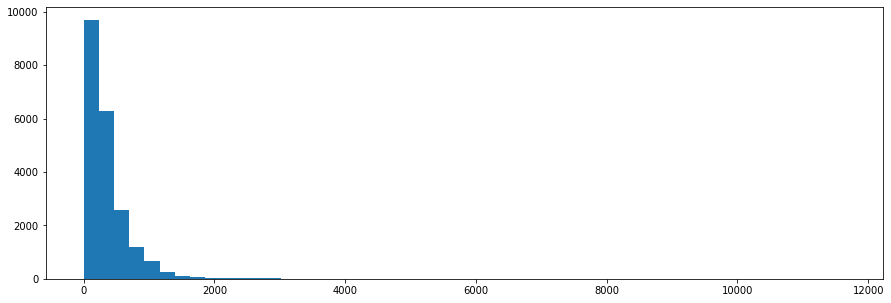

In [ ]:
# Check lenght of complaints
doc_lens = [len(item) for item in df_comp.comp_POS_removed]
plt.figure(figsize=(15,5))
plt.hist(doc_lens, bins=50)
plt.show()

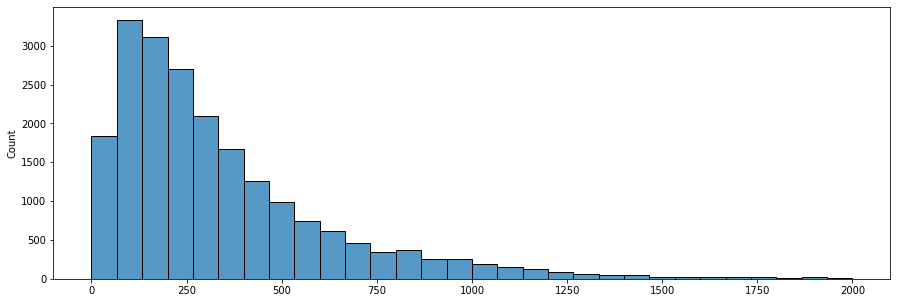

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(doc_lens, bins=30, binrange=(0,2000))
plt.show()

### Most of the complaints are in the range of 50 - 750 chars

In [ ]:
# lets see top 40 words 
from wordcloud import WordCloud

!WordCloud?

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


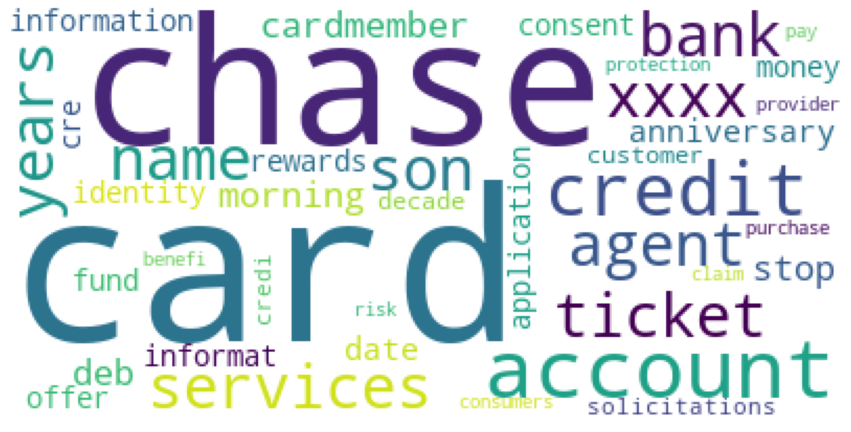

In [ ]:
import spacy
from nltk.corpus import stopwords
nltk.download('stopwords')

stoplist = set(stopwords.words("english"))
wordcloud = WordCloud(stopwords=stoplist,max_words=40, background_color='white').generate(str(df_comp.comp_POS_removed))

plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [ ]:
# test = df_comp['comp_POS_removed'][3]

# print(test)
# test = re.sub('[xx*]','',test)
# print(test)
df_comp['comp_POS_removed'] = df_comp['comp_POS_removed'].apply(lambda x: re.sub('[xx*]','',x))

In [ ]:
df_comp['comp_POS_removed'][3]

' ticket offer ticket rewards card information offer minute screen decision  bank minutes notification screen application information offer credit offer account statement ticket account application representative mins application  request application contrary fact credit account name credit report chase information credit report application error'

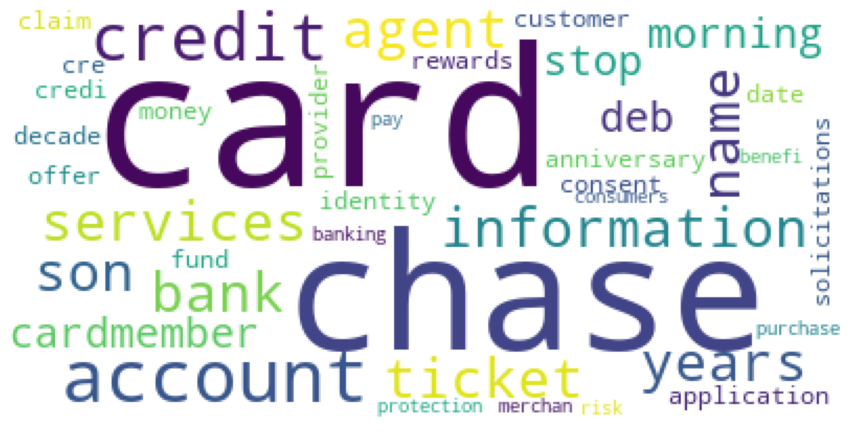

In [ ]:
wordcloud = WordCloud(stopwords=stoplist,max_words=40, background_color='white').generate(str(df_comp.comp_POS_removed))

plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [ ]:
from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
def word_freq(corpus, topn=10, ngram=1):
  vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  word_count = bag_of_words.sum(axis=0)
  words_freq = [(word, word_count[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
  return words_freq[:topn]

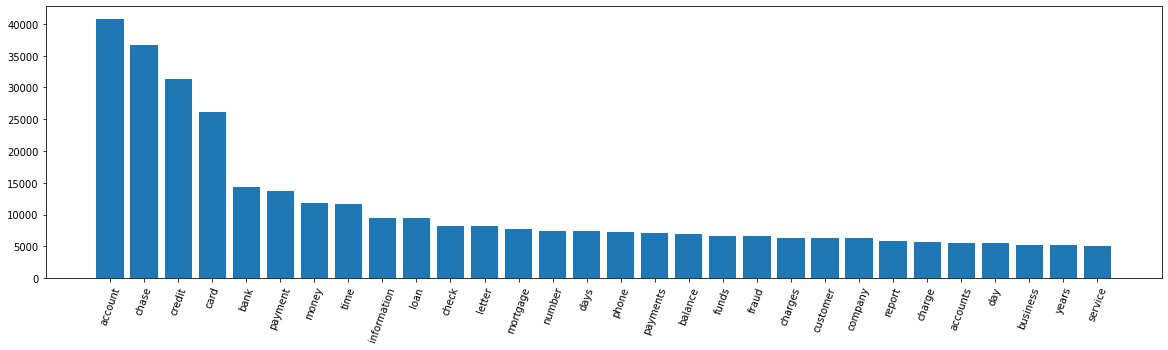

In [ ]:
top30_unigram = word_freq(df_comp.comp_POS_removed, 30, 1)
plt.figure(figsize=(20,5))
plt.bar(range(len(top30_unigram)), [val[1] for val in top30_unigram], align='center')
plt.xticks(range(len(top30_unigram)), [val[0] for val in top30_unigram])
plt.xticks(rotation=70)
plt.show()

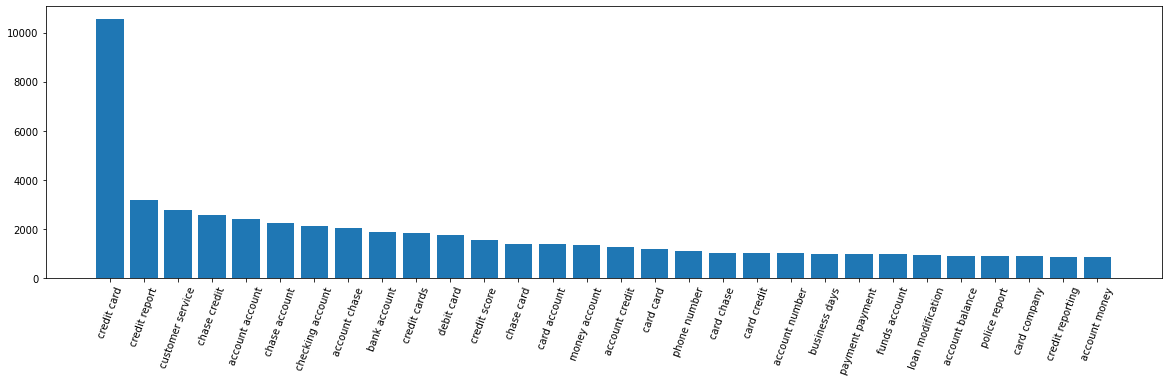

In [ ]:
top30_unigram = word_freq(df_comp.comp_POS_removed, 30, 2)
plt.figure(figsize=(20,5))
plt.bar(range(len(top30_unigram)), [val[1] for val in top30_unigram], align='center')
plt.xticks(range(len(top30_unigram)), [val[0] for val in top30_unigram])
plt.xticks(rotation=70)
plt.show()

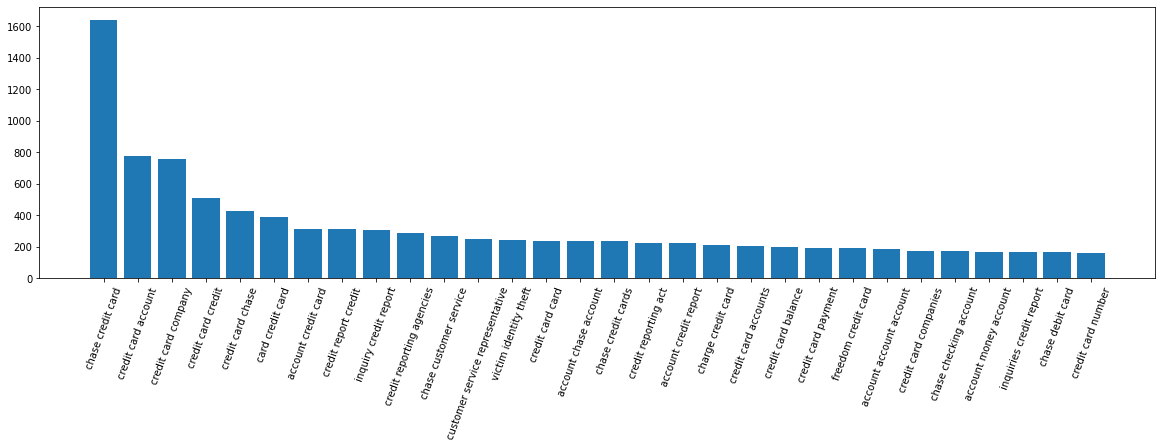

In [ ]:
top30_unigram = word_freq(df_comp.comp_POS_removed, 30, 3)
plt.figure(figsize=(20,5))
plt.bar(range(len(top30_unigram)), [val[1] for val in top30_unigram], align='center')
plt.xticks(range(len(top30_unigram)), [val[0] for val in top30_unigram])
plt.xticks(rotation=70)
plt.show()

In [ ]:
!pip install gensim

In [ ]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models import Word2Vec


# Transform word vector in tfidf vector
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
X = vectorizer.fit_transform(df_comp.comp_POS_removed) 

In [ ]:
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

,aaaratings,abandonment,abatement,abide,abiding,abilities,ability,abs,absence,absolute,absurdity,abundance,abuse,abuser,abuses,ac,acc,acccount,acccounts,acceleration,accent,accents,accept,acceptance,access,accessibility,accessories,accessory,accident,accidents,accommodation,accommodations,accomplice,accomplices,accont,accord,accordance,according,accords,accou,...,wouls,wound,wrap,wreck,wrist,wristbands,writ,write,writeoff,writer,writers,writing,writings,wrong,wrongdoing,wrongdoings,wrongs,wthe,wwwchasecom,wwwconsumerfinancegov,yard,yea,year,yearold,years,yeas,yesterday,yield,yields,yoga,youth,yr,yrs,ys,ytd,zeros,zip,zombie,zone,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106607,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049531,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.047276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.065158,0.0,0

## NMF Decomposition

In [ ]:
N_TOPICS = 5
nmf = NMF(n_components=N_TOPICS)
W = nmf.fit_transform(X)
H = nmf.components_

In [ ]:
H

array([[0.00000000e+00, 0.00000000e+00, 3.09206187e-04, ...,
        0.00000000e+00, 4.35602095e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.02230223e-03, 0.00000000e+00, 0.00000000e+00],
       [1.02169209e-03, 1.18167566e-03, 1.71633449e-03, ...,
        2.11695046e-03, 3.87311641e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.96760538e-04, 3.08197116e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.37319587e-03, 4.14751662e-03]])

In [ ]:
 print(H[1].argsort()[:10])
 idx = H[1].argsort()[::-1][:10]
 wordss = np.array(vectorizer.get_feature_names())
#  wrds = [wordss[id] for id in idx]
 print(wordss[idx])

[   0 4360 4359 4358 4355 4354 4352 4351 4349 4347]
['credit' 'report' 'inquiry' 'inquiries' 'card' 'score' 'cards' 'accounts'
 'account' 'debt']


In [ ]:
W


array([[0.02360544, 0.01519992, 0.01493187, 0.00465983, 0.00969813],
       [0.00906984, 0.00106298, 0.00308723, 0.02044055, 0.00331241],
       [0.        , 0.03828587, 0.        , 0.0250227 , 0.        ],
       ...,
       [0.01289703, 0.01263695, 0.0058267 , 0.01826797, 0.00037631],
       [0.        , 0.02496738, 0.        , 0.04999603, 0.11980901],
       [0.00922232, 0.04526835, 0.        , 0.        , 0.08889471]])

In [ ]:
words = np.array(vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((N_TOPICS, 10)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(10)]).astype(str)
for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:10]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,account,check,money,bank,funds,chase,branch,checking,deposit,accounts
Topic 2,credit,report,inquiry,inquiries,card,score,cards,accounts,account,debt
Topic 3,loan,mortgage,home,modification,chase,property,payments,years,rate,house
Topic 4,card,chase,charges,charge,credit,dispute,fraud,merchant,company,fee
Topic 5,payment,payments,balance,month,fees,fee,statement,date,time,auto


* Credit card / Prepaid card
* Bank account services
* Theft/Dispute reporting
* Mortgages/loans
* Others

In [ ]:
#create topic mapping

topic_mapping = {
    'Topic 1': 'bank_account',
    'Topic 2': 'credit_debit_card',
    'Topic 3': 'loans',
    'Topic 4': 'fraud',
    'Topic 5': 'others',
}

In [ ]:
list(topic_mapping.values())

['bank_account', 'credit_debit_card', 'loans', 'fraud', 'others']

In [ ]:
W

array([[0.02360544, 0.01519992, 0.01493187, 0.00465983, 0.00969813],
       [0.00906984, 0.00106298, 0.00308723, 0.02044055, 0.00331241],
       [0.        , 0.03828587, 0.        , 0.0250227 , 0.        ],
       ...,
       [0.01289703, 0.01263695, 0.0058267 , 0.01826797, 0.00037631],
       [0.        , 0.02496738, 0.        , 0.04999603, 0.11980901],
       [0.00922232, 0.04526835, 0.        , 0.        , 0.08889471]])

In [ ]:
# Recall the document-topic matrix, W
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(N_TOPICS)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.023605,0.015200,0.014932,0.004660,0.009698,bank_account
1,0.009070,0.001063,0.003087,0.020441,0.003312,fraud
2,0.000000,0.038286,0.000000,0.025023,0.000000,credit_debit_card
3,0.014791,0.057035,0.009724,0.016735,0.000000,credit_debit_card
4,0.067299,0.000000,0.001852,0.000000,0.000000,bank_account
5,0.000000,0.049263,0.000000,0.000000,0.000000,credit_debit_card
6,0.067728,0.000000,0.006081,0.010112,0.009263,bank_account
7,0.003153,0.000000,0.031573,0.008906,0.057474,others
8,0.028556,0.000000,0.018870,0.040688,0.004708,fraud
9,0.000000,0.111571,0.000000,0.047761,0.000000,credit_debit_card


In [ ]:
W['max_topic']

0             bank_account
1                    fraud
2        credit_debit_card
3        credit_debit_card
4             bank_account
               ...        
21067                fraud
21068                fraud
21069                fraud
21070               others
21071               others
Name: max_topic, Length: 21072, dtype: object

In [ ]:
df_comp['topic'] = W['max_topic']
df_comp.head()

,complaints,lammatized_comp,comp_POS_removed,topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,bank_account
1,i upgraded my xxxx xxxx card in xxxx and was t...,upgrade xxxx xxxx card xxxx tell agent upgrade...,card agent anniversary date agent information ...,fraud
2,chase card was reported on xxxx however fraudu...,chase card report xxxx however fraudulent appl...,card application identity consent services cre...,credit_debit_card
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx try book xxxx xxxx ticket come across...,ticket offer ticket rewards card information ...,credit_debit_card
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...,son chase account fund bank account money son ...,bank_account


In [ ]:
pd.set_option('display.max_colwidth', None)
topics = df_comp.groupby(by=['topic']).head(5)
topics.sort_values('topic')[['complaints', 'topic']]

,complaints,topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,bank_account
10,mishandling of this account by chase auto and xxxx,bank_account
6,with out notice jp morgan chase restricted my account by my debit card tuesday xxxx on thursday xxxx i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday xxxx upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,bank_account
4,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen xxxx check number xxxx claim number is xxxx with chase,bank_account
12,i opened an account with chase bank on xxxx and used a code for xxxx bonus i called to follow up on xxxxxxxx about the terms and was told everything was on the account and once i made xxxx direct deposit the bonus would be paid out in days as of xxxx i had made the required deposits and was told my account never had the coupon code applied and it was past the days to do so so no bonus would be paid,bank_account
5,can you please remove inquiry,credit_debit_card
2,chase card was reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,credit_debit

In [ ]:
pd.set_option('display.max_colwidth', 50)
df_comp.head(10)

,complaints,lammatized_comp,comp_POS_removed,topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,bank_account
1,i upgraded my xxxx xxxx card in xxxx and was t...,upgrade xxxx xxxx card xxxx tell agent upgrade...,card agent anniversary date agent information ...,fraud
2,chase card was reported on xxxx however fraudu...,chase card report xxxx however fraudulent appl...,card application identity consent services cre...,credit_debit_card
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx try book xxxx xxxx ticket come across...,ticket offer ticket rewards card information ...,credit_debit_card
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...,son chase account fund bank account money son ...,bank_account
5,can you please remove inquiry,please remove inquiry,inquiry,credit_debit_card
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,notice account debit card branch customer serv...,bank_account
7,during the summer months i experience a declin...,summer month experience decline income due emp...,summer months decline income employment month ...,others
8,on xxxx xxxx i made a payment to an online re...,xxxx xxxx make payment online retailer use c...,payment retailer chase pay chase website scam ...,fraud
9,i have a chase credit card which is incorrectl...,chase credit card incorrectly report datum cre...,chase credit card data credit report company i...,credit_debit_card


In [ ]:
# Lets start supervised learning
# split the data into train and test

# training_data = df_comp[['comp_POS_removed', 'topic']]
# training_data.columns = ['complaints_clean', 'topic']
# training_data.head(10)

training_data = df_comp[['complaints', 'topic']]
training_data.columns = ['complaints_clean', 'topic']
training_data.head(10)

,complaints_clean,topic
0,good morning my name is xxxx xxxx and i apprec...,bank_account
1,i upgraded my xxxx xxxx card in xxxx and was t...,fraud
2,chase card was reported on xxxx however fraudu...,credit_debit_card
3,on xxxx while trying to book a xxxx xxxx tic...,credit_debit_card
4,my grand son give me check for i deposit it i...,bank_account
5,can you please remove inquiry,credit_debit_card
6,with out notice jp morgan chase restricted my ...,bank_account
7,during the summer months i experience a declin...,others
8,on xxxx xxxx i made a payment to an online re...,fraud
9,i have a chase credit card which is incorrectl...,credit_debit_card


In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

training_data['topic'] = label_encoder.fit_transform(training_data['topic'])
training_data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,complaints_clean,topic
0,good morning my name is xxxx xxxx and i apprec...,0
1,i upgraded my xxxx xxxx card in xxxx and was t...,2
2,chase card was reported on xxxx however fraudu...,1
3,on xxxx while trying to book a xxxx xxxx tic...,1
4,my grand son give me check for i deposit it i...,0
5,can you please remove inquiry,1
6,with out notice jp morgan chase restricted my ...,0
7,during the summer months i experience a declin...,4
8,on xxxx xxxx i made a payment to an online re...,2
9,i have a chase credit card which is incorrectl...,1


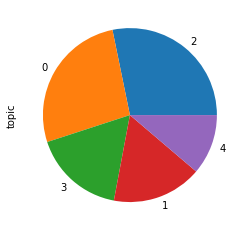

In [ ]:
training_data.topic.value_counts().plot(kind='pie', subplots=True)
plt.show()

In [ ]:
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(training_data['complaints_clean'])
print(X_train_counts[:1])

  (0, 12591)	1
  (0, 18286)	1
  (0, 18522)	1
  (0, 18593)	1
  (0, 15478)	2
  (0, 32527)	6
  (0, 1397)	2
  (0, 1769)	1
  (0, 15560)	1
  (0, 13951)	1
  (0, 33156)	1
  (0, 6697)	1
  (0, 13249)	2
  (0, 17369)	2
  (0, 22743)	1
  (0, 27611)	1
  (0, 29345)	5
  (0, 4787)	3
  (0, 2715)	2
  (0, 4267)	1
  (0, 26086)	1
  (0, 14245)	2
  (0, 32435)	1
  (0, 2032)	2
  (0, 11686)	2
  :	:
  (0, 190)	1
  (0, 1261)	1
  (0, 28803)	2
  (0, 31160)	1
  (0, 14956)	1
  (0, 3001)	1
  (0, 23354)	1
  (0, 17039)	1
  (0, 10378)	1
  (0, 18213)	1
  (0, 12121)	1
  (0, 28869)	1
  (0, 2243)	1
  (0, 5508)	1
  (0, 13106)	1
  (0, 25092)	1
  (0, 15970)	1
  (0, 29040)	1
  (0, 14673)	1
  (0, 1998)	1
  (0, 6276)	1
  (0, 270)	1
  (0, 28770)	1
  (0, 744)	1
  (0, 33167)	1


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf[:1])

  (0, 33167)	0.10186999290193399
  (0, 33156)	0.08296447943993251
  (0, 32527)	0.2363572925702842
  (0, 32435)	0.15314827564821096
  (0, 31961)	0.07019736161775716
  (0, 31913)	0.08242135607871022
  (0, 31283)	0.163797408574519
  (0, 31160)	0.19492687158511576
  (0, 29345)	0.17964451711826554
  (0, 29040)	0.045990926628629615
  (0, 28978)	0.04653249355660772
  (0, 28869)	0.06626164669316723
  (0, 28803)	0.07275237169520976
  (0, 28770)	0.16993767068833007
  (0, 27611)	0.13396687189536716
  (0, 27408)	0.11114321962774758
  (0, 26086)	0.1249492688238905
  (0, 25997)	0.08252380768113897
  (0, 25092)	0.11605553836879108
  (0, 23354)	0.13538836240801183
  (0, 22743)	0.10997708696140357
  (0, 19195)	0.043955668223970554
  (0, 18593)	0.10381092669354683
  (0, 18522)	0.03811591842576673
  (0, 18286)	0.14969289961788115
  :	:
  (0, 14245)	0.08642613272600279
  (0, 13951)	0.07299826518172209
  (0, 13249)	0.1841441381940675
  (0, 13106)	0.04520248417003542
  (0, 12591)	0.12148243839063141
  (0, 1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.topic, test_size = 0.30, random_state = 43)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (14750, 33227)
Shape of X_test: (6322, 33227)
Shape of y_train: (14750,)
Shape of y_test: (6322,)


In [ ]:
print(X_train[0])

  (0, 32881)	0.04614632897613244
  (0, 32527)	0.10354237983299434
  (0, 32344)	0.14656126142352313
  (0, 32275)	0.0743469868678125
  (0, 32140)	0.04534098056024636
  (0, 32066)	0.025237442388471847
  (0, 32047)	0.04835161401494012
  (0, 32027)	0.03056593218613883
  (0, 31961)	0.02306381728545093
  (0, 31932)	0.0221942507162451
  (0, 31913)	0.027080093228711848
  (0, 31885)	0.06839296642349968
  (0, 31881)	0.03091556510378823
  (0, 31811)	0.040654924881466215
  (0, 31759)	0.1695238104286887
  (0, 31676)	0.11246915705494512
  (0, 31318)	0.034304350173454255
  (0, 31077)	0.06324481818123037
  (0, 29403)	0.09093597989245043
  (0, 29345)	0.14165620668343692
  (0, 29236)	0.02353140217159623
  (0, 29141)	0.029823286809823744
  (0, 29040)	0.015110629575043335
  (0, 28978)	0.09173139028244116
  (0, 28916)	0.02415980307216316
  :	:
  (0, 5357)	0.12753608896198848
  (0, 4787)	0.05187089626205271
  (0, 4070)	0.022735506440114205
  (0, 4061)	0.05584028603782556
  (0, 3082)	0.03819198066468762
  (0,

In [ ]:
y_train

17439    3
2033     2
7270     2
9710     1
10930    0
        ..
18448    1
7985     3
18687    0
19776    2
14148    4
Name: topic, Length: 14750, dtype: int64

In [ ]:
# Model 1
# Naive bayes model

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)

y_pred = gnb.predict(X_test.toarray())

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

acc = accuracy_score(y_test, y_pred)
print(f'accuracy: {acc}')
f1 = f1_score(y_test, y_pred,average='weighted')
print(f'f1 score: {f1}')
# prec = precision_score(y_test, y_pred)
# print(f'precision score: {prec}')
# recall = recall_score(y_test, y_pred)
# print(f'recall score: {recall}')

accuracy: 0.3846883897500791
f1 score: 0.39851771438262534


In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', multi_class='auto')
logreg.fit(X_train.toarray(), y_train)

y_pred = logreg.predict(X_test.toarray())

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

acc = accuracy_score(y_test, y_pred)
print(f'accuracy: {acc}')
f1 = f1_score(y_test, y_pred,average='weighted')
print(f'f1 score: {f1}')
prec = precision_score(y_test, y_pred, average='weighted')
print(f'precision score: {prec}')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'recall score: {recall}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy: 0.9315090161341347
f1 score: 0.9310868480397761
precision score: 0.9323281619240187
recall score: 0.9315090161341347


In [ ]:
# #Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica

topic_mapping = {
    0: 'bank_account',
    1: 'credit_debit_card',
    2: 'loans',
    3: 'fraud',
    4: 'others',
}
y_test_val = np.vectorize(topic_mapping.get)(y_test)
y_pred_val = np.vectorize(topic_mapping.get)(y_pred)

# Making the Confusion Matrix
print(pd.crosstab(y_test_val, y_pred_val, rownames=['Actual topics'], colnames=['Predicted tropics']))

Predicted tropics  bank_account  credit_debit_card  fraud  loans  others
Actual topics                                                           
bank_account               1607                  8     11     42       1
credit_debit_card            26                926     10     55       7
fraud                        17                 10   1039     30       8
loans                        41                 29     10   1741       7
others                       45                 14     24     38     576


In [ ]:
# Testing 
import ast
test_str = 'to whom it may concern chase bank charged wrongly overdraft fees i have alert of low balance or unsuficent fee balance and always deposit immediatly to cover transactions if needed but chase always changed the order and charged me overdraft fee anyway when you call they said their per their guidelines they dont refund more then overdrawft doesnt matter bank fault or not\n\ntaken from people is money just because you can is not ok\n\nsee attached documents when chase refund they always find the way to take back what they refunded in first place'
test_str = lammatize_text(test_str)
print(test_str)
x = pos_tag(test_str)
test_str = ' '.join(x)
print(test_str)
test_str_arr = [test_str]
# count_vec = CountVectorizer()
X_sample = count_vec.transform(test_str_arr)
# print(X_sample[:1])
out = logreg.predict(X_sample.toarray())
print('out :' , topic_mapping.get(out[0]))

may concern chase bank charge wrongly overdraft fee alert low balance unsuficent fee balance always deposit immediatly cover transaction need chase always change order charge overdraft fee anyway call say per guideline not refund overdrawft not matter bank fault 

 take people money ok 

 see attach document chase refund always find way take back refund first place
concern charge overdraft fee alert balance unsuficent fee balance transaction order charge overdraft fee call guideline overdrawft people money way refund place
out : loans


In [ ]:
  mn,mn  nmm, bnm,m,b n mm nmmnbnm v # random forest
from sklearn.ensemble import RandomForestClassifier
rnd_classifer = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=43)
rnd_classifer.fit(X_train, y_train)

In [ ]:
y_pred = rnd_classifer.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'accuracy: {acc}')
f1 = f1_score(y_test, y_pred,average='weighted')
print(f'f1 score: {f1}')
prec = precision_score(y_test, y_pred, average='weighted')
print(f'precision score: {prec}')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'recall score: {recall}')

In [ ]:
# #Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica

topic_mapping = {
    1: 'bank_account',
    2: 'credit_debit_card',
    3: 'loans',
    4: 'fraud',
    5: 'others',
}
y_test_val = np.vectorize(topic_mapping.get)(y_test)
y_pred_val = np.vectorize(topic_mapping.get)(y_pred)

# Making the Confusion Matrix
print(pd.crosstab(y_test_val, y_pred_val, rownames=['Actual topics'], colnames=['Predicted tropics']))

In [ ]:
# Descision Tree
from sklearn.tree import DecisionTreeClassifier

dctree_classifer = DecisionTreeClassifier(max_depth=20, random_state=42)
dctree_classifer.fit(X_train, y_train)

In [ ]:
y_pred = dctree_classifer.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'accuracy: {acc}')
f1 = f1_score(y_test, y_pred,average='weighted')
print(f'f1 score: {f1}')
prec = precision_score(y_test, y_pred, average='weighted')
print(f'precision score: {prec}')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'recall score: {recall}')

accuracy: 0.8434163701067615
f1 score: 0.8430755518973462
precision score: 0.8442229695084094
recall score: 0.8434163701067615


In [ ]:
# #Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica

topic_mapping = {
    1: 'bank_account',
    2: 'credit_debit_card',
    3: 'loans',
    4: 'fraud',
    5: 'others',
}
y_test_val = np.vectorize(topic_mapping.get)(y_test)
y_pred_val = np.vectorize(topic_mapping.get)(y_pred)

# Making the Confusion Matrix
print(pd.crosstab(y_test_val, y_pred_val, rownames=['Actual topics'], colnames=['Predicted tropics']))

Predicted tropics  None  bank_account  credit_debit_card  fraud  loans
Actual topics                                                         
None                962            13                 71     24     21
bank_account         34           542                 72     17     15
credit_debit_card    65            63               1071     17      9
fraud                24            21                 45    350     29
loans                27            15                 59     19    630


Summary: As the results shows that we got best scores while using "Logistic Regression" and "Descision Tree". 
  
  
  Logistic Regression:
  accuracy: 0.9315090161341347
  f1 score: 0.9310868480397761

Descision Tree:

accuracy: 0.8434163701067615
f1 score: 0.8430755518973462
